# DSC180A Project 1

### Week 3

Conduct EDA on the Data

In [1]:
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import IFrame

In [2]:
# Load the Excel files into Pandas DataFrames
gis_weather_station = pd.read_excel('gis_weatherstation_shape_2024_10_04.xlsx', engine='openpyxl')
station_summary_snapshot = pd.read_excel('src_wings_meteorology_station_summary_snapshot_2023_08_02.xlsx', engine='openpyxl')
windspeed_snapshot = pd.read_excel('src_wings_meteorology_windspeed_snapshot_2023_08_02.xlsx', engine='openpyxl')

In [3]:
gis_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,elevation,twinguid,hftd,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,72,NaN,1,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,2024-10-04
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,2513,NaN,3,N,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,2024-10-04
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,1822,NaN,3,N,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,2024-10-04
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,1533,NaN,3,N,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,2024-10-04
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,448,NaN,1,N,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,2024-10-04


In [4]:
station_summary_snapshot.head()

,station,vri,alert,max_gust,99th,95th,snapshot_date
0,AMO,H,35,40,32,24,2023-08-02
1,ANE,M,35,43,32,25,2023-08-02
2,ARH,L,40,46,40,31,2023-08-02
3,AVO,H,35,43,29,24,2023-08-02
4,AVY,L,45,62,53,40,2023-08-02


In [5]:
windspeed_snapshot.head()

,date,wind_speed,station,snapshot_date
0,2012-09-14,19.0,AMO,2023-08-02
1,2012-09-15,20.0,AMO,2023-08-02
2,2012-10-14,16.0,AMO,2023-08-02
3,2012-10-26,23.0,AMO,2023-08-02
4,2012-10-27,15.0,AMO,2023-08-02


In [6]:
print(f"gis weather station shape: {gis_weather_station.shape}")
print(f"station summary shape: {station_summary_snapshot.shape}")
print(f"windspeed snapshot shape: {windspeed_snapshot.shape}")

gis weather station shape: (223, 27)
station summary shape: (216, 7)
windspeed snapshot shape: (38664, 4)


In [7]:
#Check null data for gis weather station
gis_weather_station.isna().sum()

objectid                0
weatherstationcode      0
weatherstationname      0
scadartuid              1
structureid             5
nwszone                 0
district                3
thomasbrospagegrid      2
constructionstatus      0
creationuser            0
datecreated             0
datemodified            4
lastuser                4
structureguid           6
symbolrotation          0
latitude                0
longitude               0
elevation               0
twinguid              223
hftd                    0
zone1idc                0
hftdidc                 0
gdb_geomattr_data     223
globalid                0
shape                   0
shape_srid              0
snapshot_date           0
dtype: int64

In [8]:
#Check null data for station summary
station_summary_snapshot.isna().sum()

station           0
vri              10
alert             0
max_gust          0
99th              0
95th              0
snapshot_date     0
dtype: int64

In [9]:
#Check null data for wind speed summary
windspeed_snapshot.isna().sum()

date                0
wind_speed       8724
station             0
snapshot_date       0
dtype: int64

In [10]:
station_summary_snapshot['vri'].unique().tolist()

['H', 'M', 'L', nan]

In [11]:
station_stats = station_summary_snapshot.drop(['station', 'snapshot_date'], axis=1)[station_summary_snapshot['vri'].notna()].groupby('vri').agg(['mean', 'median'])
station_stats.index = pd.Categorical(station_stats.index, categories=['L', 'M', 'H'], ordered=True)
station_stats = station_stats.sort_index()
station_stats

alert          max_gust              99th              95th       
        mean median       mean median       mean median       mean median
L  40.797619   42.5  53.892857   53.5  43.238095   43.5  33.880952   34.0
M  38.968085   37.5  49.468085   50.0  39.191489   39.5  30.968085   31.0
H  35.357143   35.0  44.571429   43.5  35.250000   34.5  27.928571   27.5

In [12]:
def impute_vri(dataset, descriptive_data, column, stats):
    ser = descriptive_data[column][stats]
    low_threshold = (ser.loc['L'] + ser.loc['M']) / 2
    medium_threshold = (ser.loc['M'] + ser.loc['H']) / 2
    
    if dataset > low_threshold:
        return 'L'
    elif dataset > medium_threshold:
        return 'M'
    else:
        return 'H'
    

station_summary_snapshot['vri'] = station_summary_snapshot.apply(lambda row: impute_vri(row['alert'], station_stats, 'alert', 'mean') 
                     if pd.isnull(row['vri']) else row['vri'], axis=1)

station_summary_snapshot['vri'].isna().sum()

0

In [13]:
windspeed_snapshot[windspeed_snapshot['wind_speed'].isna()].groupby('station').count().sort_values('date', ascending=True)

,date,wind_speed,snapshot_date
station,,,
WYN,1,0,1
SPV,1,0,1
MLG,1,0,1
MGD,1,0,1
LFR,1,0,1
...,...,...,...
BOB,134,0,134
GAV,134,0,134
DAM,136,0,136


In [14]:
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
2180,2013-12-14,611.0,BOC,2023-08-02
30293,2014-04-30,101.0,SIL,2023-08-02
30394,2020-12-03,94.0,SIL,2023-08-02
13732,2019-12-17,91.0,HHC,2023-08-02
30350,2018-01-28,89.0,SIL,2023-08-02
...,...,...,...,...
37886,2018-12-31,NaN,WST,2023-08-02
38000,2014-11-16,NaN,WSY,2023-08-02
38001,2014-11-17,NaN,WSY,2023-08-02
38002,2014-11-18,NaN,WSY,2023-08-02


In [15]:
#Dropping outlier data
windspeed_snapshot = windspeed_snapshot[(windspeed_snapshot['wind_speed'] < max(windspeed_snapshot['wind_speed']))]
windspeed_snapshot.sort_values(by='wind_speed', ascending=False)

,date,wind_speed,station,snapshot_date
30293,2014-04-30,101.0,SIL,2023-08-02
30394,2020-12-03,94.0,SIL,2023-08-02
13732,2019-12-17,91.0,HHC,2023-08-02
30350,2018-01-28,89.0,SIL,2023-08-02
30343,2017-12-07,88.0,SIL,2023-08-02
...,...,...,...,...
10511,2019-12-20,6.0,ECJ,2023-08-02
3757,2022-12-24,6.0,CAP,2023-08-02
963,2015-11-23,6.0,BFD,2023-08-02
28429,2020-12-23,6.0,RIO,2023-08-02


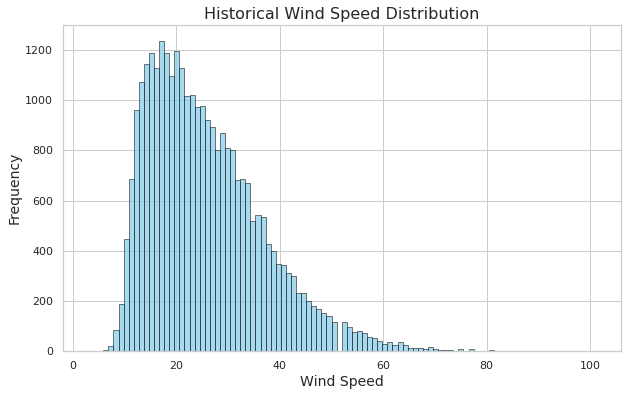

Wind Speed data is Right Skewed


In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(windspeed_snapshot['wind_speed'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('Historical Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Wind Speed data is Right Skewed')

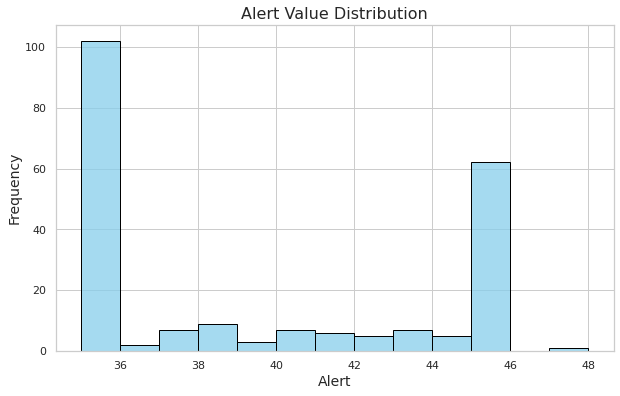

Alert Value is Bi-Modal


In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(station_summary_snapshot['alert'].dropna(), 
             bins=(max(station_summary_snapshot['alert']) - min(station_summary_snapshot['alert'])), 
             kde=False, color='skyblue', edgecolor='black')

plt.title('Alert Value Distribution', fontsize=16)
plt.xlabel('Alert', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()
print('Alert Value is Bi-Modal')

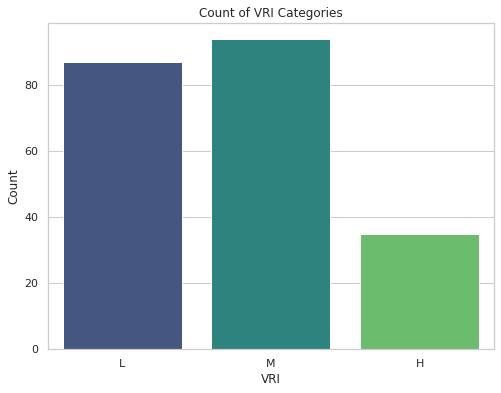

In [18]:
vri_counts = station_summary_snapshot['vri'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=vri_counts.index, y=vri_counts.values, palette='viridis', order=['L', 'M', 'H'])
plt.title('Count of VRI Categories')
plt.xlabel('VRI')
plt.ylabel('Count')
plt.show()

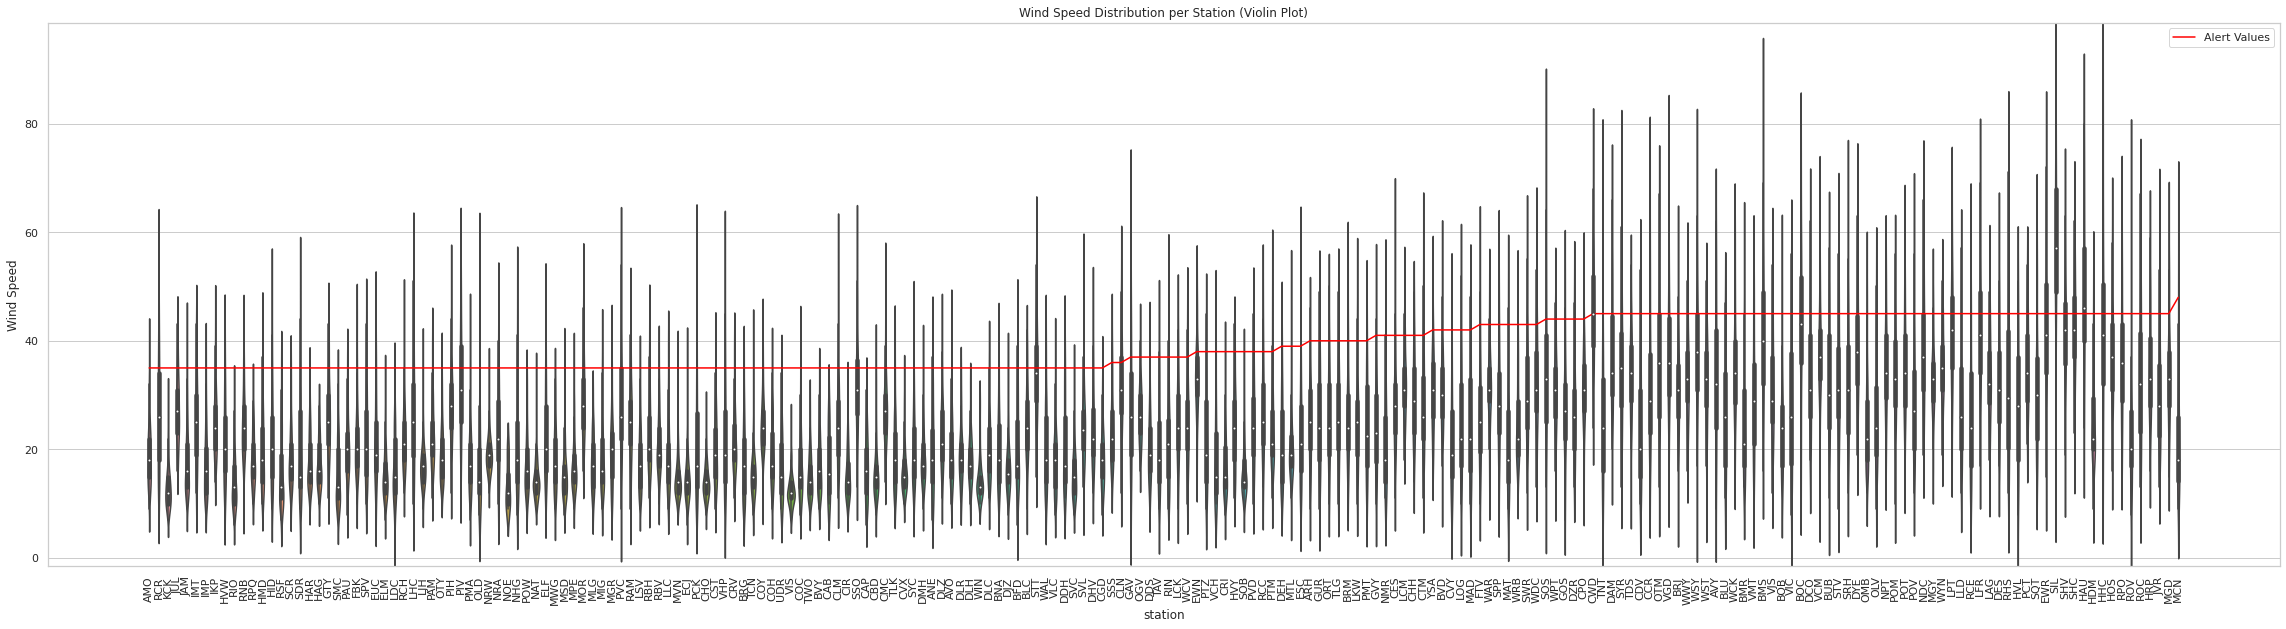

In [19]:
plt.figure(figsize=(40, 10))

#Sort station by ascending alert values
station_summary_sorted = station_summary_snapshot.sort_values(by='alert')
sorted_stations = station_summary_sorted['station'].values

# Set the x-axis order based on the sorted stations
sns.violinplot(x='station', y='wind_speed', data=windspeed_snapshot, order=sorted_stations)

# Plot the alert values
plt.plot(sorted_stations, station_summary_sorted['alert'].values, 
         marker='', color='red', label='Alert Values')

plt.xticks(rotation=90)
plt.ylabel('Wind Speed')
plt.title('Wind Speed Distribution per Station (Violin Plot)')
plt.legend()
plt.show()

In [20]:
merged_weather_station = gis_weather_station.merge(station_summary_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_weather_station.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,globalid,shape,shape_srid,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,2024-10-04,M,35,39,33,25,2023-08-02
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,2024-10-04,M,45,73,50,37,2023-08-02
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,2024-10-04,M,41,64,41,33,2023-08-02
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,2024-10-04,L,45,64,47,33,2023-08-02
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,2024-10-04,L,35,30,25,19,2023-08-02


In [21]:
san_diego_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(san_diego_map)

# Add markers to the map using the existing latitude and longitude columns
for _, row in merged_weather_station.iterrows():
    tooltip_text = f"""
    <strong>{row['weatherstationname']}</strong><br>
    Station Code: {row['weatherstationcode']}<br>
    VRI Value: {row['vri']}<br>
    Alert: {row['alert']}<br>
    """
    
    if row['vri'] == 'L':
        icon_color = 'lightred'
    elif row['vri'] == 'M':
        icon_color = 'orange'
    else:
        icon_color = 'red'
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.Icon(color=icon_color, icon="info-sign"),
        popup=tooltip_text,
        tooltip=tooltip_text
    ).add_to(marker_cluster)  # Add the marker to the MarkerCluster instead of the map

# Save the map
san_diego_map.save('san_diego_weather_stations_map.html')

# Display the map
IFrame('san_diego_weather_stations_map.html', width=800, height=500)

In [22]:
merged_station_wind_speed = merged_weather_station.merge(windspeed_snapshot, left_on='weatherstationcode', right_on='station').drop(columns=['station'])
merged_station_wind_speed.head()

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,snapshot_date_x,vri,alert,max_gust,99th,95th,snapshot_date_y,date,wind_speed,snapshot_date
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-10,11.0,2023-08-02
1,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-19,16.0,2023-08-02
2,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-20,17.0,2023-08-02
3,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2012-12-25,13.0,2023-08-02
4,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,2024-10-04,M,35,39,33,25,2023-08-02,2013-04-18,28.0,2023-08-02


<Figure size 864x576 with 0 Axes>

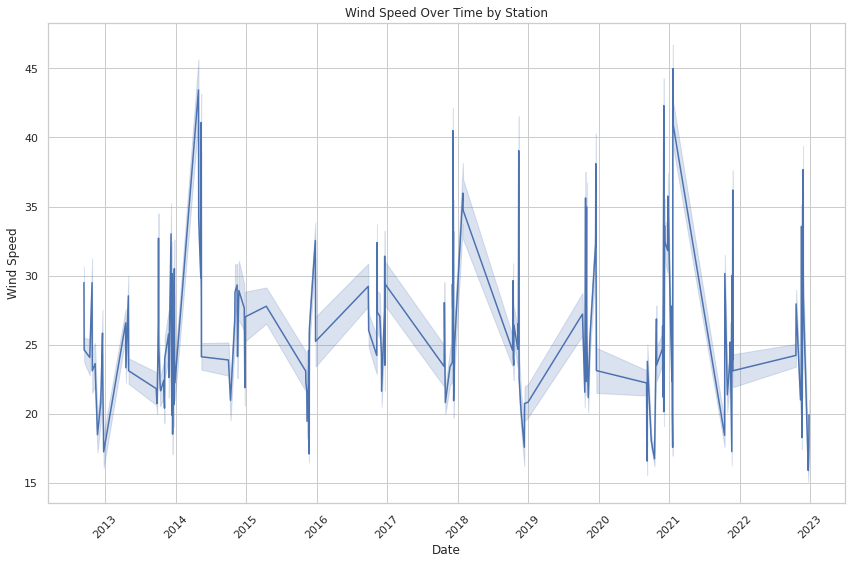

In [23]:
plt.figure(figsize=(12, 8))

merged_station_wind_speed['date'] = pd.to_datetime(merged_station_wind_speed['date'])

plt.figure(figsize=(12, 8))

# Plotting the wind speed over time
sns.lineplot(x='date', y='wind_speed', data=merged_station_wind_speed)

plt.title('Wind Speed Over Time by Station')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.xticks(rotation=45)

# Set x-axis major locator to year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set minor locator to show ticks for each month
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Show grid lines
plt.grid(visible=True)

# Show the plot
plt.tight_layout()
plt.show()

### Week 4

1) Calculating PSPS Probability for each Weather Station  
2) Visualizing Weather Station wind speed distributions against its wind speed threshold, and displaying its calculated PSPS Probability

In [24]:
merged_station_wind_speed.shape

(30120, 36)

In [25]:
wind_speed_count = merged_station_wind_speed.groupby('weatherstationcode')[['wind_speed']].count().rename(columns={'wind_speed':'wind_speed_count'})

windspeed_above_threshold = merged_station_wind_speed[merged_station_wind_speed['wind_speed'] > merged_station_wind_speed['alert']]
windspeed_count_above_threshold = windspeed_above_threshold.groupby('weatherstationcode')[['wind_speed']].count().rename(columns={'wind_speed':'above_threshold_count'})

combined_count = windspeed_count_above_threshold.merge(wind_speed_count, on="weatherstationcode", how='right')
combined_count['PSPS_probability'] = combined_count['above_threshold_count'] / combined_count['wind_speed_count']
combined_count

,above_threshold_count,wind_speed_count,PSPS_probability
weatherstationcode,,,
AMO,1.0,166,0.006024
ANE,3.0,179,0.016760
ARH,9.0,179,0.050279
AVO,4.0,179,0.022346
AVY,22.0,116,0.189655
...,...,...,...
WST,3.0,61,0.049180
WSY,43.0,176,0.244318
WWY,18.0,179,0.100559


In [26]:
weather_station_psps = gis_weather_station.merge(combined_count, left_on='weatherstationcode', right_index=True, how='left')
weather_station_psps['above_threshold_count'] = weather_station_psps['above_threshold_count'].fillna(0)
weather_station_psps['wind_speed_count'] = weather_station_psps['wind_speed_count'].fillna(0)
weather_station_psps['PSPS_probability'] = weather_station_psps['PSPS_probability'].fillna(0)
weather_station_psps

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
0,1,CBD,Carlsbad,5158.0,P124785,Coastal-243,6.0,1126-G1,A,seu_gis_elec,...,N,N,NaN,{ED5DE7F2-F63A-41EA-BA80-9F71495334A3},POINT (1540299.9388 12029375.0425),4431,2024-10-04,2.0,171.0,0.011696
1,2,CCR,Cuca Ranch,1915.0,Z118027,Mountain-258,3.0,1052-A5,A,seu_gis_elec,...,N,Y,NaN,{82759049-437B-4A5C-8796-10C8D7098C5B},POINT (1667010.27856 12088881.1767),4431,2024-10-04,25.0,179.0,0.139665
2,3,CES,Country Estates,1995.0,Z416611,Inland Valley-250,3.0,1153-G7,A,seu_gis_elec,...,N,Y,NaN,{6A3A6DAD-6CD1-43B7-A0FE-72A52A46A4F7},POINT (1703876.2967 11989778.75946),4431,2024-10-04,10.0,173.0,0.057803
3,208,ROV,Rim of the Valley,4818.0,Z416170,Inland Valley-250,3.0,1071-B1,A,gwharris,...,N,Y,NaN,{AD1AEA81-BC74-4954-8D25-421C79F40D88},POINT (1646528.56915 12083236.45575),4431,2024-10-04,4.0,49.0,0.081633
4,5,CHO,Chollas Lake,5182.0,P970712,Inland Valley-250,1.0,1270-C7,A,seu_gis_elec,...,N,N,NaN,{1294A90A-9558-458E-8EA5-9D15B2A16D8D},POINT (1619955.10724 11883209.4286),4431,2024-10-04,0.0,117.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,146,HAU,Hauser Mountain,4828.0,Z972858,Mountain-258,4.0,1316-J1,A,calonzo,...,N,Y,NaN,{EFF383D5-266E-4B6D-A25B-C71D3B52247B},POINT (1776616.0495 11855234.4288),4431,2024-10-04,27.0,49.0,0.551020
219,223,BOB,Bob Owens Canyon,4841.0,Z571472,Inland Valley-250,4.0,1295-A7,A,CLCosby,...,N,Y,NaN,{9D545CF5-97C2-4EA1-A794-DEDCFD1D4437},POINT (1732301.64404 11860546.56055),4431,2024-10-04,4.0,45.0,0.088889
220,224,MWG,MT. WOODSON GOLF CLUB,4827.0,P518334,INLAND VALLEY-250,3.0,1171-D3,A,KSTETS,...,N,Y,NaN,{BCF2F0F6-C481-43A2-B237-DD05D83E0D13},POINT (1648988.038 11985389.44244),4431,2024-10-04,0.0,49.0,0.000000
221,4,CGD,Cole Grade,1957.0,Z416193,Inland Valley-250,3.0,1070-G1,A,seu_gis_elec,...,N,Y,NaN,{D0BC3059-6829-459B-AD6E-3446161600EF},POINT (1635642.92426 12082797.67706),4431,2024-10-04,1.0,179.0,0.005587


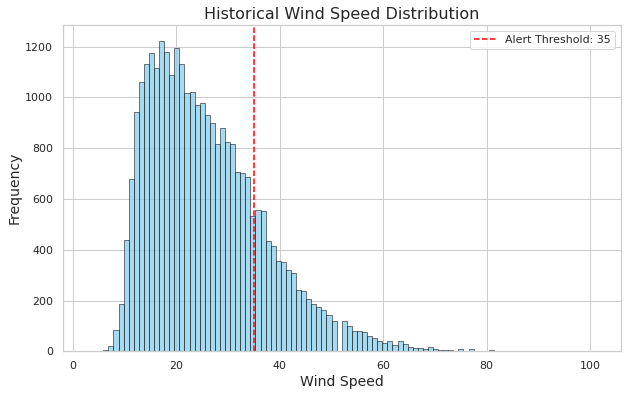

Wind Speed data is Right Skewed


In [27]:
alert_threshold = min(merged_station_wind_speed['alert'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(merged_station_wind_speed['wind_speed'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('Historical Wind Speed Distribution', fontsize=16)
plt.xlabel('Wind Speed', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(x=alert_threshold, color='red', linestyle='--', label=f'Alert Threshold: {alert_threshold}')
plt.legend()

plt.show()
print('Wind Speed data is Right Skewed')

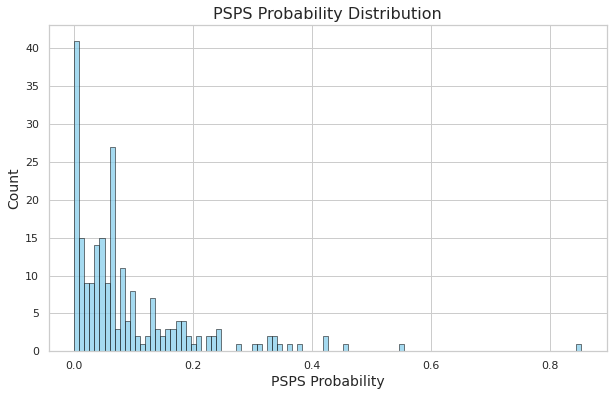

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.histplot(weather_station_psps['PSPS_probability'].dropna(), bins=100, kde=False, color='skyblue', edgecolor='black')

plt.title('PSPS Probability Distribution', fontsize=16)
plt.xlabel('PSPS Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

In [29]:
weather_station_psps[weather_station_psps['PSPS_probability'] > 0.80]

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
12,13,SIL,Sill Hill,5164.0,P258571,Mountain-258,4.0,1195-G3,A,seu_gis_elec,...,N,Y,NaN,{613E692C-CF98-43EF-BB63-5F83E9E77004},POINT (1749936.5284 11962741.62946),4431,2024-10-04,151.0,177.0,0.853107


In [30]:
san_diego_map = folium.Map(location=[32.7157, -117.1611], zoom_start=10)

# Prepare data for the heatmap
heat_data = [[row['latitude'], row['longitude'], row['PSPS_probability']] for _, row in weather_station_psps.iterrows()]

# Add the heatmap with adjusted parameters
HeatMap(
    heat_data, 
    radius=15,         # Adjust radius for wider spread
    blur=10,           # Adjust blur for smoother transitions
    min_opacity=0,   # Adjust transparency for better visibility
    max_val=1.0,       # Assuming PSPS_probability values are between 0 and 1
    gradient={0: 'blue', 0.5: 'lime', 1: 'red'}  # Custom gradient
).add_to(san_diego_map)

# Save the map
san_diego_map.save('san_diego_weather_stations_map_with_heatmap.html')

# Display the map
IFrame('san_diego_weather_stations_map_with_heatmap.html', width=800, height=500)

/tmp/ipykernel_615/1436374191.py:7: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


#### Participation Week 4

In [34]:
weather_station_psps[weather_station_psps['wind_speed_count'] == 0]

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
23,24,PSQC1,San Pasqual RAWS,19170.0,NaN,Inland Valley-250,3.0,1130-H7,A,seu_gis_elec,...,N,Y,NaN,{2AEDCEB8-308D-4209-BCEF-C8EF2CE1D022},POINT (1636678.4517 12012548.8901),4431,2024-10-04,0.0,0.0,0.0
26,27,PZAC1,Pala RAWS,19160.0,NaN,Inland Valley-250,3.0,1029-E5,A,seu_gis_elec,...,N,Y,NaN,{DD97A667-79C0-48B0-BF0B-49E123AA3A0F},POINT (1608030.63306 12110670.62823),4431,2024-10-04,0.0,0.0,0.0
83,84,TNSC1,Mountain Springs Grade RAWS,19180.0,NaN,Desert-232,NaN,NaN,A,seu_gis_elec,...,N,N,NaN,{F0BA7ADC-FF42-4D26-BADC-14F75C8AEF00},POINT (1918953.83795 11862248.423),4431,2024-10-04,0.0,0.0,0.0
97,98,BAJC1,Barrett RAWS,19090.0,Z105010,Inland Valley-250,4.0,1315-A1,A,seu_gis_elec,...,N,Y,NaN,{D6368869-868B-44DD-BEB7-76715F034612},POINT (1732857.3047 11858482.70184),4431,2024-10-04,0.0,0.0,0.0
115,117,ALLC1,Aliso Laguna RAWS,NaN,NaN,Coastal-552,NaN,951-B4,A,rfeura,...,N,N,NaN,{34DB73D6-40EC-409A-A0E6-C3814BA1A3CC},POINT (1410885.988 12174983.9287),4431,2024-10-04,0.0,0.0,0.0
133,135,BVDC1,MISSION VALLEY RAWS,19200.0,NaN,COASTAL-243,2.0,1269-D1,A,crfranco,...,N,N,NaN,{449FEDE4-48BB-4F62-BE60-E80720DB0A44},POINT (1598663.48285 11900349.9035),4431,2024-10-04,0.0,0.0,0.0


In [32]:
weather_station_psps[weather_station_psps['wind_speed_count'] > 0].sort_values(by=['wind_speed_count', 'PSPS_probability'], ascending=True)

,objectid,weatherstationcode,weatherstationname,scadartuid,structureid,nwszone,district,thomasbrospagegrid,constructionstatus,creationuser,...,zone1idc,hftdidc,gdb_geomattr_data,globalid,shape,shape_srid,snapshot_date,above_threshold_count,wind_speed_count,PSPS_probability
214,218,NOE,NORTH ESCONDIDO,4831.0,P315443,INLAND VALLEY-250,3.0,1109-J5,A,ad-AJRobert,...,N,N,NaN,{FABF7BE3-E655-4892-BAFA-249BA3FA6A04},POINT (1614939.2846 12035314.9702),4431,2024-10-04,0.0,14.0,0.000000
149,151,CAB,Caballo Park,4826.0,P314747,Inland Valley-250,3.0,1110-E4,A,jatamayo,...,N,Y,NaN,{60ED7DE9-6E6F-4ACB-835C-B99F0AB202B8},POINT (1630241.2799 12036771.8626),4431,2024-10-04,0.0,24.0,0.000000
157,211,DAM,MORENA DAM,4829.0,P42834,MOUNTAIN-258,4.0,1297-A5,A,asiman,...,N,Y,NaN,{9DC0EC85-1E2C-4D54-9006-E4AFBD88277B},POINT (1779985.3101 11865090.35004),4431,2024-10-04,10.0,43.0,0.232558
137,139,DLH,De Luz Heights,4838.0,Z322621,Inland Valley-250,3.0,997-C3,A,RPhilli1,...,N,Y,NaN,{D78BC63B-B994-4AF2-B94A-E89DA9E5856B},POINT (1554820.4465 12136181.48236),4431,2024-10-04,0.0,45.0,0.000000
219,223,BOB,Bob Owens Canyon,4841.0,Z571472,Inland Valley-250,4.0,1295-A7,A,CLCosby,...,N,Y,NaN,{9D545CF5-97C2-4EA1-A794-DEDCFD1D4437},POINT (1732301.64404 11860546.56055),4431,2024-10-04,4.0,45.0,0.088889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,155,STT,Shockey Truck Trail,5131.0,P46507,Mountain-258,4.0,1318-G4,A,seu_gis_elec,...,N,Y,NaN,{7F2180DC-3611-4F3A-904D-B68D53756D1F},POINT (1817821.0435 11846595.57043),4431,2024-10-04,76.0,179.0,0.424581
159,161,LAG,Laguna,1968.0,P40066,Mountain-258,4.0,1237-J3,R,seu_gis_elec,...,N,Y,NaN,{ACC7851A-8A44-445E-946C-F70D5E20B7E6},POINT (1802464.58704 11923398.8896),4431,2024-10-04,22.0,358.0,0.061453
187,191,LAG,Laguna,1968.0,P258651,Mountain-258,4.0,1237-J3,P,cray,...,N,Y,NaN,{02A77C09-9D50-4E03-85F8-E0E5A63D7A26},POINT (1802693.0082 11923201.08057),4431,2024-10-04,22.0,358.0,0.061453
113,16,SYR,Santa Ysabel Ranch,5130.0,P413688,Mountain-258,3.0,1115,R,seu_gis_elec,...,N,Y,NaN,{FEDC7A4C-1085-401B-8A3E-F6E0765E7D99},POINT (1736519.0329 12027484.4275),4431,2024-10-04,62.0,358.0,0.173184


In [33]:
wind_speed_count.shape

(215, 1)